# Importy

In [3]:
import numpy as np
import torch
import os
import tqdm
import torchcrepe
from torch.utils.data import Dataset, DataLoader
from torch import nn
import time
import matplotlib.pyplot as plt
from scipy.io import wavfile
import librosa
import soundfile as sf
import tarfile

In [4]:
pretrained_folder = "pretrained_model"
os.makedirs(pretrained_folder, exist_ok=True)

pretrained_folder = "input"
os.makedirs(pretrained_folder, exist_ok=True)

In [5]:
!wget "https://zenodo.org/record/3685367/files/TinySOL.tar.gz?download=1" -O TinySOL.tar.gz

--2025-11-18 23:04:49--  https://zenodo.org/record/3685367/files/TinySOL.tar.gz?download=1
Resolving zenodo.org (zenodo.org)... 137.138.52.235, 188.185.43.153, 188.185.48.75, ...
Connecting to zenodo.org (zenodo.org)|137.138.52.235|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/3685367/files/TinySOL.tar.gz [following]
--2025-11-18 23:04:49--  https://zenodo.org/records/3685367/files/TinySOL.tar.gz
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 1026917185 (979M) [application/octet-stream]
Saving to: ‘TinySOL.tar.gz’

TinySOL.tar.gz      100%[===================>] 979.34M  76.5MB/s    in 13s     

2025-11-18 23:05:04 (72.9 MB/s) - ‘TinySOL.tar.gz’ saved [1026917185/1026917185]



In [6]:
with tarfile.open("TinySOL.tar.gz", "r:gz") as tar:
    tar.extractall(path="input/data")

/tmp/ipykernel_12481/3370536987.py:2: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path="input/data")


In [7]:
!wget -O "pretrained_model/groove_clean.pkl" "https://filedn.com/lAEQ8ShUNLzjcOukVHsWG0z/ArtistProtectModels/SingleEchoes/DDSP/groove_clean.pkl"

--2025-11-18 23:05:39--  https://filedn.com/lAEQ8ShUNLzjcOukVHsWG0z/ArtistProtectModels/SingleEchoes/DDSP/groove_clean.pkl
Resolving filedn.com (filedn.com)... 23.109.93.100
Connecting to filedn.com (filedn.com)|23.109.93.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19375602 (18M) [application/octet-stream]
Saving to: ‘pretrained_model/groove_clean.pkl’

pretrained_model/gr 100%[===================>]  18.48M  44.8MB/s    in 0.4s    

2025-11-18 23:05:40 (44.8 MB/s) - ‘pretrained_model/groove_clean.pkl’ saved [19375602/19375602]



# Narzędzia

In [8]:
def upsample_time(X, hop_length, mode='nearest'):
    """
    Upsample a tensor by a factor of hop_length along the time axis

    Parameters
    ----------
    X: torch.tensor(M, T, N)
        A tensor in which the time axis is axis 1
    hop_length: int
        Upsample factor
    mode: string
        Mode of interpolation.  'nearest' by default to avoid artifacts
        where notes in the violin jump by large intervals

    Returns
    -------
    torch.tensor(M, T*hop_length, N)
        Upsampled tensor
    """
    X = X.permute(0, 2, 1)
    X = nn.functional.interpolate(X, size=hop_length*X.shape[-1], mode=mode)
    return X.permute(0, 2, 1)

def fftconvolve(x, h):
    """
    Perform a fast convolution of two tensors across their last axis
    by using the FFT. Since the DFT assumes circularity, zeropad them
    appropriately before doing the FFT and slice them down afterwards

    The length of the result will be equivalent to np.convolve's 'same'

    Parameters
    ----------
    x: torch.tensor(..., N1)
        First tensor
    h: torch.tensor(..., N2)
        Second tensor

    Returns
    -------
    torch.tensor(..., max(N1, N2))
    Tensor resulting from the convolution of x and y across their last axis,
    """
    N = max(x.shape[-1], h.shape[-1])
    if x.shape[-1] != h.shape[-1]:
        # Zeropad so they're equal
        if x.shape[-1] < N:
            x = nn.functional.pad(x, (0, N-x.shape[-1]))
        if h.shape[-1] < N:
            h = nn.functional.pad(h, (0, N-h.shape[-1]))
    x = nn.functional.pad(x, (0, N))
    h = nn.functional.pad(h, (0, N))
    X = torch.fft.rfft(x)
    H = torch.fft.rfft(h)
    y = torch.fft.irfft(X*H)
    return y[..., 0:N]


def plot_stft_comparison(F, L, X, Y, reverb, losses=torch.tensor([]), win=1024, sr=16000):
    """
    Some code to help compare the STFTs of ground truth and output audio, while
    also plotting the frequency, loudness, and reverb to get an idea of what the
    inputs to the network were that gave rise to these ouputs.  It's very helpful
    to call this method while monitoring the training of the network

    Parameters
    ----------
    F: torch.tensor(n_batches, n_samples/hop_length, 1)
         Tensor holding the pitch estimates for the clips
    L: torch.tensor(n_batches, n_samples/hop_length, 1)
         Tensor holding the loudness estimates for the clips
    X: torch.tensor(n_batches, n_samples, 1)
        Ground truth audio
    Y: torch.tensor(n_batches, n_samples, 1)
        Output audio from the network->decoder
    reverb: torch.tensor(reverb_len)
        The learned reverb
    losses: list
        A list of losses over epochs over time
    win: int
        Window length to use in the STFT
    sr: int
        Sample rate of audio (used to help make proper units for time and frequency)
    """
    hop = 256
    hann = torch.hann_window(win).to(X)
    SX = torch.abs(torch.stft(X.squeeze(), win, hop, win, hann, return_complex=True))
    SY = torch.abs(torch.stft(Y.squeeze(), win, hop, win, hann, return_complex=True))
    print(SX.shape)
    extent = (0, SX.shape[2]*hop/sr, SX.shape[1]*sr/win, 0)
    plt.subplot(321)
    plt.imshow(torch.log10(SX.detach().cpu()[0, :, :]), aspect='auto', cmap='magma', extent=extent)
    plt.title("Ground Truth")
    plt.ylim([0, 8000])
    plt.xlabel("Time (Sec)")
    plt.ylabel("Frequency (hz)")

    plt.subplot(322)
    plt.imshow(torch.log10(SY.detach().cpu()[0, :, :]), aspect='auto', cmap='magma', extent=extent)
    plt.title("Synthesized")
    plt.ylim([0, 8000])
    plt.xlabel("Time (Sec)")
    plt.ylabel("Frequency (hz)")

    plt.subplot(323)
    plt.plot(F.detach().cpu()[0, :, 0])
    plt.title("Fundamental Frequency")
    plt.xlabel("Window index")
    plt.ylabel("Hz")
    plt.subplot(324)
    plt.plot(L.detach().cpu()[0, :, 0])
    plt.title("Loudness")
    plt.xlabel("Window Index")
    plt.ylabel("Z-normalized dB")
    if torch.numel(losses) > 0:
        plt.subplot(325)
        plt.plot(losses.detach().cpu().numpy().flatten())
        plt.yscale("log")
        plt.title("Losses (Current {:.3f})".format(losses[-1]))
        plt.xlabel("Epoch")
    plt.subplot(326)
    plt.plot(reverb.detach().cpu().flatten())
    plt.title("Impulse Response")
    plt.xlabel("Sample index")

################################################
# Loudness code modified from original Google Magenta DDSP implementation in tensorflow
# https://github.com/magenta/ddsp/blob/86c7a35f4f2ecf2e9bb45ee7094732b1afcebecd/ddsp/spectral_ops.py#L253
# which, like this repository, is licensed under Apache2 by Google Magenta Group, 2020
# Modifications by Chris Tralie, 2023

def power_to_db(power, ref_db=0.0, range_db=80.0, use_tf=True):
    """Converts power from linear scale to decibels."""
    # Convert to decibels.
    db = 10.0*np.log10(np.maximum(power, 10**(-range_db/10)))
    # Set dynamic range.
    db -= ref_db
    db = np.maximum(db, -range_db)
    return db

def extract_loudness(x, sr, hop_length, n_fft=2048):
    """
    Extract the loudness in dB by using an A-weighting of the power spectrum
    (section B.1 of the paper)

    Parameters
    ----------
    x: ndarray(N)
        Audio samples
    sr: int
        Sample rate (used to figure out frequencies for A-weighting)
    hop_length: int
        Hop length between loudness estimates
    n_fft: int
        Number of samples to use in each window
    """
    # Computed centered STFT
    S = librosa.stft(x, n_fft=n_fft, hop_length=hop_length, win_length=n_fft, center=True)

    # Compute power spectrogram
    amplitude = np.abs(S)
    power = amplitude**2

    # Perceptual weighting.
    freqs = np.arange(S.shape[0])*sr/n_fft
    a_weighting = librosa.A_weighting(freqs)[:, None]

    # Perform weighting in linear scale, a_weighting given in decibels.
    weighting = 10**(a_weighting/10)
    power = power * weighting

    # Average over frequencies (weighted power per a bin).
    avg_power = np.mean(power, axis=0)
    loudness = power_to_db(avg_power)
    return np.array(loudness, dtype=np.float32)

################################################


HANN_TABLE = {}
def mss_loss(X, Y, eps=1e-7):
    loss = 0
    win = 64
    while win <= 2048:
        hop = win//4
        if not win in HANN_TABLE:
            HANN_TABLE[win] = torch.hann_window(win).to(X)
        hann = HANN_TABLE[win]
        SX = torch.abs(torch.stft(X.squeeze(), win, hop, win, hann, return_complex=True))
        SY = torch.abs(torch.stft(Y.squeeze(), win, hop, win, hann, return_complex=True))
        loss_win = torch.sum(torch.abs(SX-SY)) + torch.sum(torch.abs(torch.log(SX+eps)-torch.log(SY+eps)))
        loss += loss_win/torch.numel(SX)
        win *= 2
    return loss

def extract_pitch_torchcrepe(x: np.ndarray, sr: int, hop_length: int, device: str = None,
                             fmin: int = 32, fmax: int = 2000, model: str = "tiny"):
    """
    Return (pitch, confidence) as torch tensors on CPU.
    - x: 1D numpy array, audio in range [-1,1]
    - sr: sample rate
    - hop_length: hop length in samples (matching how you compute loudness)
    - device: "cuda" or "cpu" or None -> auto (cuda if available)
    - fmin,fmax: search range in Hz
    - model: 'tiny' or 'full' (smaller = faster)
    """
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    # torchcrepe expects a float tensor shaped (batch, length)
    audio = torch.from_numpy(x.astype(np.float32)).unsqueeze(0)  # (1, L)
    audio = audio.to(device)

    # hop_length for torchcrepe is in samples
    hop = int(hop_length)

    # Predict. API: torchcrepe.predict(audio, sr, hop_length, fmin, fmax, model=..., batch_size=..., device=..., return_periodicity=True, decoder=...)
    # wrap in no_grad
    with torch.no_grad():
        try:
            frequency, periodicity = torchcrepe.predict(
                audio, sr, hop, fmin, fmax, model=model, batch_size=512,
                device=device, return_periodicity=True
            )
        except TypeError:
            frequency, periodicity = torchcrepe.predict(
                audio, sr, hop, fmin, fmax, model=model, batch_size=512,
                device=device, return_periodicity=True
            )

    # frequency, periodicity: shape (batch, frames)
    frequency = frequency[0].cpu()     # (frames,)
    periodicity = periodicity[0].cpu() # (frames,)
    return frequency, periodicity


# Synteza

In [9]:
def synthesize_subtractive(S, hop_length):
    """
    Perform subtractive synthesis by converting frequency domain transfer
    functions into causal, zero-phase, windowed impulse responses

    Parameters
    ----------
    S: n_batches x time x n_bands
        Subtractive synthesis parameters
    hop_length: int
        Hop length between subtractive synthesis windows

    Returns
    -------
    torch.tensor(n_batches, time*hop_length, 1)
        Subtractive synthesis audio components for each clip
    """
    # Put an imaginary component of all 0s across a new last axis
    # https://pytorch.org/docs/stable/generated/torch.view_as_complex.html
    S = torch.stack([S, torch.zeros_like(S)], -1)
    S = torch.view_as_complex(S)
    # Do the inverse real DFT (assuming symmetry)
    h = torch.fft.irfft(S)

    # Shift the impulse response to zero-phase
    nh = h.shape[-1]
    h = torch.roll(h, nh//2, -1)
    # Apply hann window
    h = h*torch.hann_window(nh, dtype=h.dtype, device=h.device)
    # Shift back to causal
    h = nn.functional.pad(h, (0, hop_length-nh))
    h = torch.roll(h, -nh//2, -1)

    # Apply the impulse response to random noise in [-1, 1]
    noise = torch.rand(h.shape[0],h.shape[1],hop_length).to(h.device)
    noise = noise*2 - 1
    noise = fftconvolve(noise, h).contiguous()

    # Flatten nonoverlapping samples to one contiguous stream
    return noise.reshape(noise.shape[0], noise.shape[1]*noise.shape[2], 1)


def synthesize_additive(A, C, F, S, hop_length, sr, reverb=torch.tensor([])):
    """
    Perform additive synthesis on a batch of parameters
    Parameters
    ----------
    A: torch.tensor(n_batches, n_times, 1)
        Amplitudes
    C: torch.tensor(n_batches, n_times, n_harmonics)
        Harmonic relative amplitudes
    F: torch.tensor(n_batches, n_times, 1)
        Frequencies
    S: torch.tensor(n_batches, n_times, n_bands)
        Subtractive synthesis parameters
    hop_length: int
        Hop length

    """
    AUp = upsample_time(A, hop_length)
    CUp = upsample_time(C, hop_length)
    FUp = upsample_time(F, hop_length)
    FUp = torch.cumsum(FUp, axis=1)/sr
    harmonics = torch.arange(1, C.shape[-1]+1).to(CUp.device)
    harmonics = harmonics.view(1, 1, C.shape[-1])
    FUp = FUp*harmonics
    Y = AUp*CUp*torch.sin(2*np.pi*FUp)
    Y = torch.sum(Y, axis=-1, keepdims=True)
    YS = synthesize_subtractive(S, hop_length)
    Y = Y + YS
    NR = reverb.detach().cpu().numpy().size
    if NR > 0:
        Y = fftconvolve(Y.squeeze(), reverb.view(1, NR)).unsqueeze(-1)
    return Y

# Dataset

In [10]:
def walk_dir(dir:str, ext="wav"):
    """
    Return an array listing the paths to each .wav file in the
    given directory and any subdirectories
    Parameters:
        dir: str of the directory to walk through

    Returns:
        [strings]: array of strings, each representing a unique file path
                in the given directory that ends with .wav
    """
    files = []
    for filename in os.listdir(dir):
        f = os.path.join(dir, filename)
        if os.path.isfile(f):
            if str(f).endswith(f".{ext}"):
                files.append(f)
        if os.path.isdir(f):
            append_this = walk_dir(f)
            for each in append_this:
                files.append(each)
    return files

class InstrumentDataset(Dataset):
    def __init__(self, device, folder, ext, sr, hop_length,
                 sample_len=3, samples_per_epoch=5000):
        """
        Parameters
        ----------
        device: string
            Device name
        folder: string
            Path to folder
        ext: string
            Extension of files to look for in folder
        sr: int
            Sample rate
        hop_length: int
            Hop length between frequency and loudness frames
        sample_len: float
            Length, in seconds, of each sample
        samples_per_epoch: int
            What to consider the length of this data
        """
        self.timesteps = int(sample_len*sr/hop_length)
        self.samples_per_epoch = samples_per_epoch
        self.hop_length = hop_length

        self.loudnesses = []
        self.pitches = []
        self.confidences = []
        self.xs = []
        files = walk_dir(folder, ext)
        for audio_filename in tqdm.tqdm(files):
            x, self.sr = librosa.load(audio_filename, sr=sr)
            x = x/np.max(np.abs(x))
            if x.size < self.timesteps:
                continue

            ## Step 1: Compute loudness
            loudness = extract_loudness(x, sr, hop_length)

            ## Step 2: Compute pitch
            device = "cuda" if torch.cuda.is_available() else "cpu"
            try:
                pitch, confidence = extract_pitch_torchcrepe(x, sr, hop_length, device=device, model="tiny")
                pitch = pitch.reshape(-1)
                confidence = confidence.reshape(-1)
            except RuntimeError as e:
                if "out of memory" in str(e):
                    print("GPU memory full, trying CPU...")
                    pitch, confidence = extract_pitch_torchcrepe(x, sr, hop_length, device="cpu", model="tiny")
                    pitch = pitch.reshape(-1)
                    confidence = confidence.reshape(-1)
                else:
                    raise e

            ## Step 3: Crop all aspects to be the same
            N = min(x.size, loudness.size, pitch.shape[0])
            if N >= self.timesteps:
                # Only add if the clip is long enough
                self.loudnesses.append(loudness[0:N])
                self.pitches.append(pitch[0:N])
                self.confidences.append(confidence[0:N])
                self.xs.append(x[0:N*hop_length])
            else:
                tqdm.tqdm.write(f"Skipping {audio_filename}: too short at {N*hop_length/sr} seconds")

        ## Step 4: Normalize loudnesses
        all_loudnesses = np.concatenate(self.loudnesses)
        self.loudness_mu = np.mean(all_loudnesses)
        self.loudness_std = np.std(all_loudnesses)
        for i, loudness in enumerate(self.loudnesses):
            self.loudnesses[i] = (loudness-self.loudness_mu)/self.loudness_std




    def __len__(self):
        return self.samples_per_epoch

    def __getitem__(self, idx):
        """
        Return a tuple (x, pitch, loudness)
        """
        # First extract a random tune
        idx = np.random.randint(len(self.loudnesses))
        x = self.xs[idx]
        pitch = self.pitches[idx]
        confidence = self.confidences[idx]
        loudness = self.loudnesses[idx]

        # Next extract random index into latent variables
        idx = np.random.randint(len(pitch)-self.timesteps)
        # Extract and scale audio
        x = x[idx*self.hop_length:(idx+self.timesteps)*self.hop_length]
        x = torch.from_numpy(x).view(x.size, 1)
        # Extract pitch and loudness
        pitch = pitch[idx:idx+self.timesteps].view(self.timesteps, 1)
        confidence = confidence[idx:idx+self.timesteps].view(self.timesteps, 1)
        loudness = torch.from_numpy(loudness[idx:idx+self.timesteps]).view(self.timesteps, 1)
        return x, pitch, confidence, loudness


# Model

In [11]:
class MLP(nn.Module):
    def __init__(self, depth=3, n_input=1, n_units=512):
        super(MLP, self).__init__()
        layers = []
        for i in range(depth):
            if i == 0:
                layers.append(nn.Linear(n_input, n_units))
            else:
                layers.append(nn.Linear(n_units, n_units))
            layers.append(nn.LayerNorm(normalized_shape=n_units))
            layers.append(nn.LeakyReLU())
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

    def get_num_parameters(self):
        total = 0
        for p in self.parameters():
            total += np.prod(p.shape)
        return total

def modified_sigmoid(x):
    return 2*torch.sigmoid(x)**np.log(10) + 1e-7


class DDSPDecoder(nn.Module):
    def __init__(self, mlp_depth, n_units, n_harmonics, n_bands, hop_length, sr, reverb_len, data=None):
        """
        Parameters
        ----------
        mlp_depth: int
            Depth of each multilayer perceptron
        n_units: int
            Number of units in each multilayer perceptron
        n_harmonics: int
            Number of harmonic amplitudes to output
        n_bands: int
            Number of bands to use in the noise filter
        hop_length: int
            Hop length to use when doing style transfer
        sr: int
            Sample rate
        reverb_len: int
            Number of samples for reverb signal
        data: InstrumentData
            Dataset that this is trained on; will be used to save off loudness_mu
            and loudness_std for style transfer
        """
        super(DDSPDecoder, self).__init__()
        self.FMLP = MLP(mlp_depth, 2, n_units)
        self.LMLP = MLP(mlp_depth, 1, n_units)

        self.gru = nn.GRU(input_size=n_units*2, hidden_size=n_units, num_layers=1, bias=True, batch_first=True)
        self.FinalMLP = MLP(mlp_depth, n_units*3, n_units)
        self.HarmonicsDecoder = nn.Linear(n_units, n_harmonics)
        self.AmplitudeDecoder = nn.Linear(n_units, 1)
        self.FFTDecoder = nn.Linear(n_units, n_bands)
        self.reverb = nn.Parameter(torch.rand(reverb_len)*1e-4-0.5e-4)
        self.n_harmonics = n_harmonics
        self.n_bands = n_bands
        self.hop_length = hop_length
        self.sr = sr
        if data:
            self.loudness_mu = data.loudness_mu
            self.loudness_std = data.loudness_std
        else:
            self.loudness_mu = 0
            self.loudness_std = 1

    def forward(self, F, FConf, L, respect_nyquist=False):
        """
        Estimate the additive and subtractive synthesis parameters
        from pitch and loudness trajectories

        Parameters
        ----------
        F: torch.tensor(n_batches, n_times, 1)
            Frequencies
        FConf: torch.tensor(n_batches, n_times, 1)
            Confidences of frequencies
        L: torch.tensor(n_batches, n_times, 1)
            Loudnesses

        Returns
        -------
        A: torch.tensor(n_batches, n_times, 1)
            Amplitudes
        C: torch.tensor(n_batches, n_times, n_harmonics)
            Harmonic relative amplitudes
        S: torch.tensor(n_batches, n_times, n_bands)
            Subtractive synthesis parameters
        reverb: torch.tensor(n_reverb)
            Estimated impulse response
        """
        FOut = self.FMLP(torch.cat((F, FConf), dim=-1))
        LOut = self.LMLP(L)
        FL = torch.concatenate((FOut, LOut), axis=2)
        G = self.gru(FL)[0]
        G = torch.concatenate((FOut, LOut, G), axis=2)
        final = self.FinalMLP(G)
        S = modified_sigmoid(self.FFTDecoder(final))
        A = modified_sigmoid(self.AmplitudeDecoder(final))
        C = modified_sigmoid(self.HarmonicsDecoder(final))
        # Zero out amplitudes above the nyquist rate
        if respect_nyquist:
            FMul = torch.arange(1, self.n_harmonics+1).view(1, 1, self.n_harmonics).to(C.device)
            CFreqs = F*FMul
            C[CFreqs >= self.sr//2] = 0
        C = C/(1e-8+torch.sum(C, axis=2, keepdims=True))
        return A, C, S, torch.tanh(self.reverb)

    def get_num_parameters(self):
        total = 0
        for p in self.parameters():
            total += np.prod(p.shape)
        return total

    def load_from_file(self, path):
        res = torch.load(path, weights_only=False)
        self.loudness_mu  = res["loudness_mu"]
        self.loudness_std = res["loudness_std"]
        del res["loudness_mu"]
        del res["loudness_std"]
        self.load_state_dict(res)

    def style_transfer(self, x, device, pitch_device="", pitch_shift=0):
        if len(pitch_device) == 0:
            pitch_device = device
        with torch.no_grad():
            x = x*0.5/np.max(np.abs(x))
            tic = time.time()
            try:
                pitch, confidence = extract_pitch_torchcrepe(x, self.sr, self.hop_length, device=pitch_device, model="tiny")
            except RuntimeError as e:
                if "out of memory" in str(e):
                    print("Ran out of GPU memory, trying CPU for pitch")
                    pitch, confidence = extract_pitch_torchcrepe(x, self.sr, self.hop_length, device="cpu", model="tiny")
                else:
                    raise e
            pitch = pitch.to(device)
            confidence = confidence.to(device)
            if pitch_shift != 0:
                pitch *= 2**(pitch_shift/12)
            print("Elapsed time pitch:", time.time()-tic)
            loudness = extract_loudness(x, self.sr, self.hop_length)
            loudness = (loudness-self.loudness_mu)/self.loudness_std

            tic = time.time()
            N = len(x)
            X = torch.from_numpy(x)
            X = X.view(1, N, 1).to(device)

            N = min(len(loudness), len(pitch))
            loudness = loudness[0:N]
            pitch = pitch[0:N]
            confidence = confidence[0:N]
            L = torch.from_numpy(loudness)
            L = L.view(1, N, 1)
            L = L.to(device)
            F = pitch.view(1, N, 1)
            F = F.to(device)
            FConf = confidence.view(1, N, 1)
            FConf = FConf.to(device)
            A, C, P, reverb = self.forward(F, FConf, L)
            y = synthesize_additive(A, C, F/2, P, self.hop_length, self.sr, reverb)

            print("Elapsed time synth:", time.time()-tic)
            return y.detach().cpu().numpy().flatten()

# Trening

In [12]:
def do_training(dataset_path, output_path, device='cuda', ext='wav', sr=44100, hop_length=441,
                batch_size=16, num_epochs=100, samples_per_epoch=5000, reverb_len=44100):
    if not os.path.exists(output_path):
        os.mkdir(output_path)

    data = InstrumentDataset(device, dataset_path, ext, sr, hop_length, samples_per_epoch=samples_per_epoch)

    ## Step 2: Create model with a test batch
    model = DDSPDecoder(mlp_depth=3, n_units=512, n_harmonics=50, n_bands=65,
                        hop_length=hop_length, sr=sr, reverb_len=reverb_len, data=data)
    model = model.to(device)

    ## Step 3: Setup the loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    # Start at learning rate of 0.001, rate decay of 0.98 factor every 10,000 steps
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10000/len(data), gamma=0.98)

    # and we use this to update the parameters
    train_losses = []

    plt.figure(figsize=(12, 12))
    for epoch in range(num_epochs):
        tic = time.time()
        loader = DataLoader(data, batch_size=batch_size, shuffle=True)

        train_loss = 0
        for batch_num, (X, F, FConf, L) in tqdm.tqdm(enumerate(loader)): # Go through each mini batch
            # Move inputs/outputs to GPU
            X = X.to(device)
            F = F.to(device)
            FConf = FConf.to(device)
            L = L.to(device)
            # Reset the optimizer's gradients
            optimizer.zero_grad()
            # Run the model on all inputs
            A, C, P, reverb = model(F, FConf, L)
            # Run the synthesizer
            Y = synthesize_additive(A, C, F, P, hop_length, sr, reverb)
            # Compute the loss function comparing X to Y
            loss = mss_loss(X, Y)
            # Compute the gradients of the loss function with respect
            # to all of the parameters of the model
            loss.backward()
            # Update the parameters based on the gradient and
            # the optimization scheme
            optimizer.step()
            train_loss += loss.item()
        train_loss = train_loss/len(loader)
        train_losses.append(train_loss)
        scheduler.step()

        # Synthesize training data example
        x = X[0, :, 0].detach().cpu().numpy().flatten()
        y = Y[0, :, 0].detach().cpu().numpy().flatten()
        d = np.array([x, y])
        d = np.array(d*32768, dtype=np.int16)
        wavfile.write(f"{output_path}/Epoch{epoch}.wav", sr, d.T)

        plt.clf()
        plot_stft_comparison(F, L, X, Y, reverb, torch.tensor(train_losses))
        plt.tight_layout()
        plt.savefig(f"{output_path}/Epoch{epoch}.png", bbox_inches='tight')
        state = model.state_dict()
        state["loudness_mu"] = model.loudness_mu
        state["loudness_std"] = model.loudness_std
        torch.save(state, f"{output_path}/model.pkl")

        print("Epoch {}, loss {:.3f}, elapsed time {:.3f}".format(epoch, train_loss, time.time()-tic))

# Ewaluacja pretrenowanego modelu

Evaluating...
Elapsed time pitch: 0.25597453117370605
Elapsed time synth: 0.04083132743835449


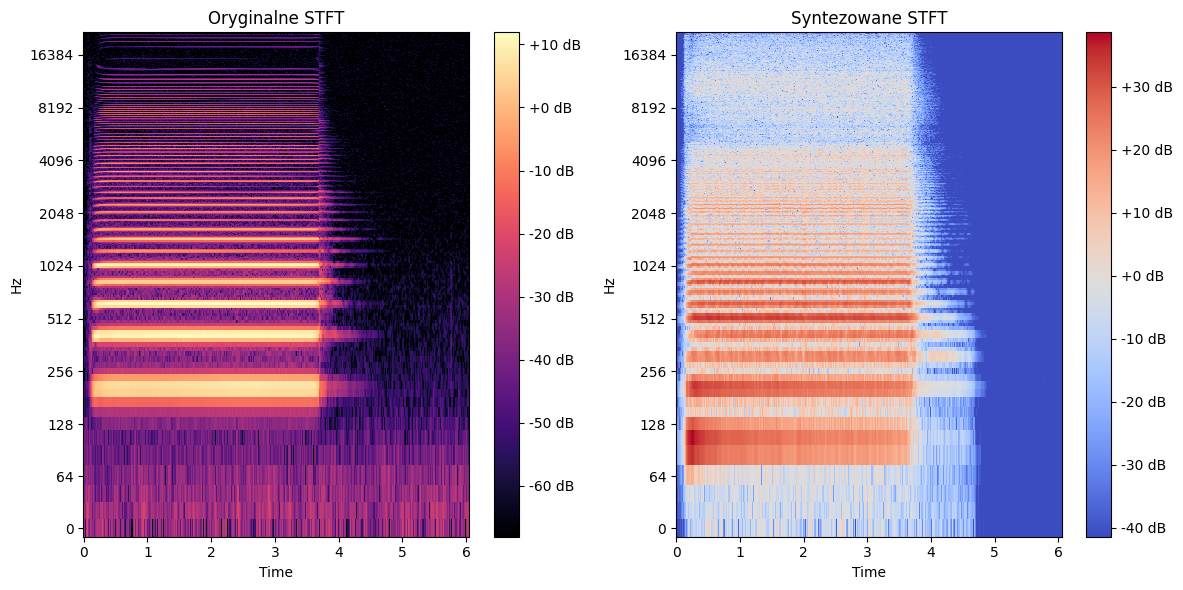

Ewaluacja zakończona. Syntezowane audio zapisane w: output/eval_output.wav


In [14]:
def do_evaluation(model_path, input_audio_path, output_audio_path, device='cuda', pitch_shift=0, sr=44100, hop_length=441, reverb_len=44100 ):
    model = DDSPDecoder(mlp_depth=3, n_units=512, n_harmonics=50, n_bands=65,
                        hop_length=hop_length, sr=sr, reverb_len=reverb_len)
    model.load_from_file(model_path)
    model = model.to(device)
    model.eval()
    print("Evaluating...")

    # Load example audio for evaluation
    x, sr = librosa.load(input_audio_path, sr=sr)
    x = x.astype(np.float32)

    # Do style transfer (synthesis based on input)
    y = model.style_transfer(x, device=device, pitch_shift=pitch_shift)

    # Save synthesised audio
    os.makedirs(os.path.dirname(output_audio_path), exist_ok=True)
    sf.write(output_audio_path, y, sr)

    # Make visual comparison
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plt.title("Oryginalne STFT")
    Sx = np.abs(librosa.stft(x))
    librosa.display.specshow(librosa.amplitude_to_db(Sx), sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')

    plt.subplot(122)
    plt.title("Syntezowane STFT")
    Sy = np.abs(librosa.stft(y))
    librosa.display.specshow(librosa.amplitude_to_db(Sy), sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')

    plt.tight_layout()
    plt.savefig(output_audio_path.replace('.wav', '_comparison.png'))
    plt.show()

    print(f"Ewaluacja zakończona. Syntezowane audio zapisane w: {output_audio_path}")

# Evaluation function call
do_evaluation('pretrained_model/groove_clean.pkl', 'input/data/Keyboards/Accordion/ordinario/Acc-ord-G#3-mf-alt1-N.wav', 'output/eval_output.wav')

# Testowy trening i ewaluacja wytrenowanego modelu

100%|██████████| 284/284 [00:53<00:00,  5.27it/s]
7it [00:02,  3.38it/s]


torch.Size([4, 513, 517])
Epoch 0, loss 18.861, elapsed time 2.992


7it [00:00, 15.17it/s]


torch.Size([4, 513, 517])
Epoch 1, loss 14.296, elapsed time 1.485


7it [00:00, 15.84it/s]


torch.Size([4, 513, 517])
Epoch 2, loss 13.585, elapsed time 1.215


7it [00:00, 15.80it/s]


torch.Size([4, 513, 517])
Epoch 3, loss 13.655, elapsed time 1.206


7it [00:00, 16.35it/s]


torch.Size([4, 513, 517])
Epoch 4, loss 13.666, elapsed time 1.178


7it [00:00, 15.67it/s]


torch.Size([4, 513, 517])
Epoch 5, loss 13.258, elapsed time 1.132


7it [00:00, 13.75it/s]


torch.Size([4, 513, 517])
Epoch 6, loss 12.968, elapsed time 1.350


7it [00:00, 16.65it/s]


torch.Size([4, 513, 517])
Epoch 7, loss 13.377, elapsed time 1.126


7it [00:00, 17.31it/s]


torch.Size([4, 513, 517])
Epoch 8, loss 12.990, elapsed time 1.067


7it [00:00, 15.79it/s]


torch.Size([4, 513, 517])
Epoch 9, loss 12.893, elapsed time 1.089


7it [00:00, 17.05it/s]


torch.Size([4, 513, 517])
Epoch 10, loss 12.836, elapsed time 1.093


7it [00:00, 16.02it/s]


torch.Size([4, 513, 517])
Epoch 11, loss 13.074, elapsed time 1.303


7it [00:00, 16.70it/s]


torch.Size([4, 513, 517])
Epoch 12, loss 13.179, elapsed time 1.056


7it [00:00, 17.50it/s]


torch.Size([4, 513, 517])
Epoch 13, loss 12.493, elapsed time 1.085


7it [00:00, 15.48it/s]


torch.Size([4, 513, 517])
Epoch 14, loss 12.554, elapsed time 1.060


7it [00:00, 17.36it/s]


torch.Size([4, 513, 517])
Epoch 15, loss 12.530, elapsed time 1.094


7it [00:00, 17.30it/s]


torch.Size([4, 513, 517])
Epoch 16, loss 12.376, elapsed time 1.193


7it [00:00, 16.63it/s]


torch.Size([4, 513, 517])
Epoch 17, loss 13.263, elapsed time 1.109


7it [00:00, 16.64it/s]


torch.Size([4, 513, 517])
Epoch 18, loss 12.972, elapsed time 1.045


7it [00:00, 17.41it/s]


torch.Size([4, 513, 517])
Epoch 19, loss 12.612, elapsed time 1.041


7it [00:00, 16.48it/s]


torch.Size([4, 513, 517])
Epoch 20, loss 12.467, elapsed time 1.258


7it [00:00, 17.21it/s]


torch.Size([4, 513, 517])
Epoch 21, loss 12.769, elapsed time 1.023


7it [00:00, 17.02it/s]


torch.Size([4, 513, 517])
Epoch 22, loss 12.680, elapsed time 1.030


7it [00:00, 16.20it/s]


torch.Size([4, 513, 517])
Epoch 23, loss 12.721, elapsed time 1.034


7it [00:00, 16.64it/s]


torch.Size([4, 513, 517])
Epoch 24, loss 12.531, elapsed time 1.091


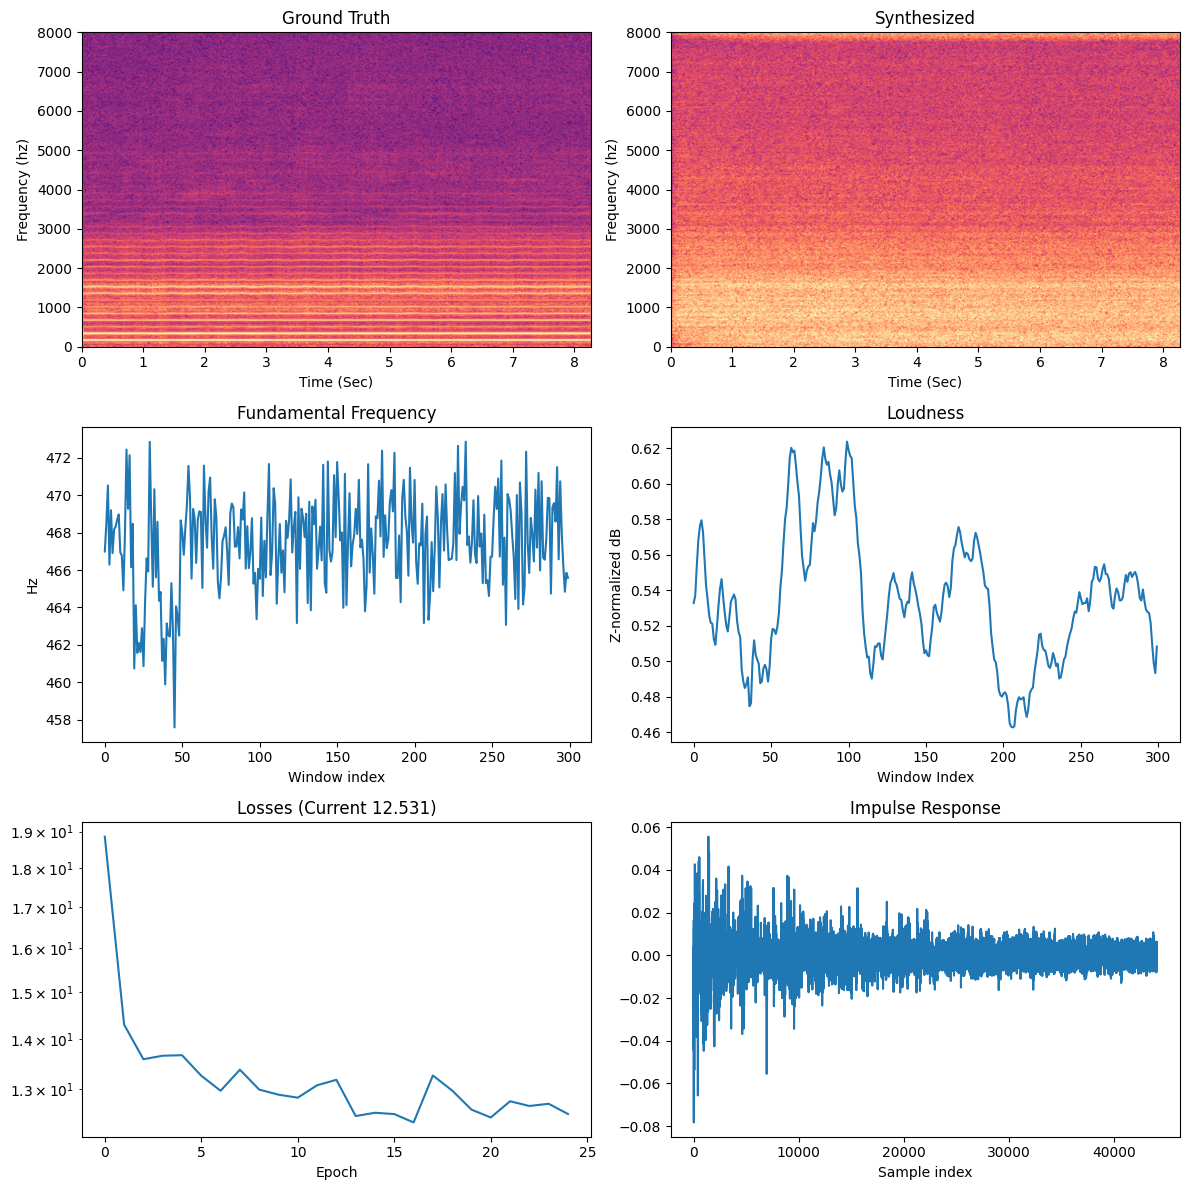

In [15]:
do_training('input/data/Strings/Violin/ordinario', 'results', device='cuda', ext='wav', sr=44100, hop_length=441, batch_size=16, num_epochs=25, samples_per_epoch=100, reverb_len=44100)

Evaluating...
Elapsed time pitch: 0.23475933074951172
Elapsed time synth: 0.04676198959350586


/home/szymon_pc/STUDIA/WIMU/EchoMark/.venv/lib/python3.12/site-packages/librosa/core/convert.py:1869: RuntimeWarning: divide by zero encountered in log10
  + 2 * np.log10(f_sq)


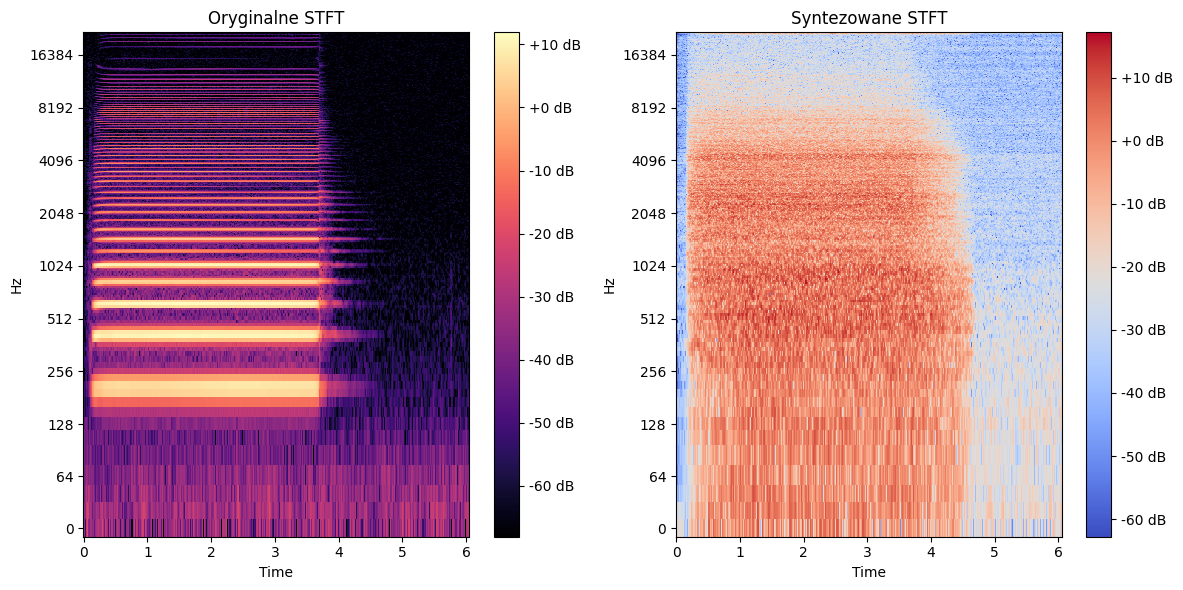

Ewaluacja zakończona. Syntezowane audio zapisane w: output/my_model_eval_output.wav


In [16]:
do_evaluation('results/model.pkl', 'input/data/Keyboards/Accordion/ordinario/Acc-ord-G#3-mf-alt1-N.wav', 'output/my_model_eval_output.wav')